# Predicting the Risk of Diabetes
#### Group 14 - Angela Yang, Tina Chen, Tom Cui, Yiyang Zhang

## Introduction: ##

Diabetes is a chronic health condition where blood glucose is unable to enter cells due to the lack of insulin facilitating this exchange (NIDDK, 2016). With diabetes being one of the top causes of death in North America (CDC, 2022), the need to determine the best health indicators becomes increasingly important for the correct diagnosis of diabetes. 

For our project, we will try to answer this predictive question: Given the health profile of a patient, how accurate can our classification model predict potential diabetes cases based on the selected explanatory variables?

We will perform our analysis using a dataset from Kaggle, originally from the National Institute of Diabetes and Digestive and Kidney Diseases. It contains a variety of health indicators including pregnancies, glucose, blood pressure, skin thickness, insulin, BMI, diabetes pedigree function, age, and outcome, which are used to determine whether the individual was diagnosed with diabetes based on these indicators. For our classification model, we chose to use glucose, blood pressure, insulin, and BMI as our predictor variables to make a diagnosis.
- Glucose is a specific type of sugar and is measured by the concentration present in the blood
- Blood pressure it the measure of pressure in blood vessels
- Insulin is a hormone that regulates the levels of glucose in the blood
- BMI stands for Body Mass Index that measures the body fat of a person based on their weight and height

#### Figure & Table Legends
- Table 1: Original data frame
- Table 2: Tidied data frame
- Table 3: Summary statistics (min, mean, max) for each variable
- Table 4:
- Figure 1:
- Figure 2:

## Methods & Results: ##
#### Project Explanation ####
This project will use classification with k-nearest neighbors to predict potential diabetes cases based on a patient's BMI, blood glucose levels, blood pressure, and insulin levels. 

Our methodology is divided into the following sections:
1. Preliminary exploratory data analysis
2. Building the classifier
3. Final visualization of results

### 1. Preliminary Exploratory Data Analysis
#### Loading and Tidying the Data
To start, we load in the external libraries needed to implement functions into our code that do not load by default. Since our data set is comma separated, we use the read_csv() function to read the file into R.

In [2]:
#disabled warning messages
defaultW <- getOption("warn")
options(warn = -1)

#Attaching libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
library(readr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
#Load in the data using its URL
diabetes_data <- read.csv(url("https://raw.githubusercontent.com/angela-yang349/dsci-100-2022w2-group-14-007/main/diabetes.csv"))
print("Table 1")
head(diabetes_data)

[1] "Table 1"


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,0,0,25.6,0.201,30,0


Next, we tidied the data in a few ways:
- Change the outcome column from a character type to a factor type because the "0" and "1" represent the absence and presence of diabetes, respectively 
- Filter for observations that have a pregnancy value of bigger than 0 since we are only studying pregnant people
- Replace 0's in the data set with NA to indicate that those observations are incomplete and will not be used in our analysis

In [39]:
#Tidying the data
diabetes_data_processed <- diabetes_data |>
    filter(Pregnancies!=0 & Glucose !=0 & BloodPressure !=0 & SkinThickness !=0 & Insulin !=0) |>
    mutate(Outcome = as_factor(Outcome))

print("Table 2")
head(diabetes_data_processed)

[1] "Table 2"


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<fct>
1,1,89,66,23,94,28.1,0.167,21,0
2,3,78,50,32,88,31.0,0.248,26,1
3,2,197,70,45,543,30.5,0.158,53,1
4,1,189,60,23,846,30.1,0.398,59,1
5,5,166,72,19,175,25.8,0.587,51,1
6,1,103,30,38,83,43.3,0.183,33,0


#### Compiling Initial Statistics
We calculated summary statistics including min, mean, and max, in order to gain information about the observations in the data set. Before performing the summary, we made sure to change all columns, except for the "Outcome" column, to a numeric type. The values are put into "Table 1" which shows us the range for each variable in the data set. This will be useful for the classification as it sets the scale and range of the numbers that will be used in the training data.

In [36]:
diabetes_data_summary <- diabetes_data_processed |>
  mutate_all(~ifelse(is.na(.), NA, as.numeric(as.character(.))))

diabetes_min <- diabetes_data_summary |>
    map_df(min, na.rm = TRUE) |>
    round(digits = 3) |>
    pivot_longer(cols = Pregnancies:Outcome,
                 names_to = "variables",
                 values_to = "min")

diabetes_mean <- diabetes_data_summary |>
    map_df(mean, na.rm = TRUE) |>
    round(digits = 3) |>
    pivot_longer(cols = Pregnancies:Outcome,
                 names_to = "variables",
                 values_to = "mean")

diabetes_max <- diabetes_data_summary |>
    map_df(max, na.rm = TRUE) |>
    round(digits = 3) |>
    pivot_longer(cols = Pregnancies:Outcome,
                 names_to = "variables",
                 values_to = "max")

#Table 1
diabetes_summary <- diabetes_min |>
    full_join(diabetes_mean) |>
    full_join(diabetes_max)
print("Table 3")
diabetes_summary

Joining, by = "variables"
Joining, by = "variables"


[1] "Table 3"


variables,min,mean,max
<chr>,<dbl>,<dbl>,<dbl>
Pregnancies,1.000,4.495,17.000
Glucose,44.000,121.463,199.000
BloodPressure,24.000,72.182,122.000
SkinThickness,7.000,28.788,99.000
Insulin,15.000,154.955,846.000
BMI,18.200,31.994,57.300
DiabetesPedigreeFunction,0.084,0.464,2.329
Age,21.000,34.193,81.000
Outcome,0.000,0.350,1.000


From the table above, we can see that there is a variety of scaling for the variables. Insulin has the largest range in value which shows that it has the most potential to impact the outcome while diabetes pedigree function has the smallest range in value which shows that it has the least potential to impact the outcome.

#### Assessing and Choosing Predictors
Available Predictors and Units:
1. Pregnancies (number of times)
2. Glucose (mg/dL)
3. Blood Pressure (mm Hg)
4. Skin Thickness (mm)
5. Insulin (mu U/ml)
6. BMI (kg/m^2)
7. Diabetes pedigree function
8. Age (year)
9. Outcome

We will be using the forward selection method to choose how many of these predictors to use in order to obtain the highest accuracy for our model.

In [40]:
set.seed(1400)

#split the data into training and testing set
df_split <- initial_split(diabetes_data_processed,prop=0.75, strata = Outcome)
diabetes_training <- training(df_split)
diabetes_testing <- testing(df_split)

In [41]:
set.seed(1400)

names <- colnames(diabetes_training |> select(-Outcome))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric()) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |> 
    set_mode("classification") 

diabetes_vfold <- vfold_cv(diabetes_training, v = 5, strata = Outcome) 

n_total <- length(names) 

selected <- c() 

for (i in 1:n_total) { 
    accs <- list() 
    models <- list() 
    for (j in 1:length(names)) { 
        preds_new <- c(selected, 
                       names[[j]]) 
        model_string <- paste("Outcome", 
                              "~", paste(preds_new, 
                                         collapse="+")) 

diabetes_recipe <- recipe(as.formula(model_string), data = diabetes_training) |> 
        step_scale(all_predictors()) |> 
        step_center(all_predictors()) 
        
acc <- workflow() |> 
        add_recipe(diabetes_recipe) |> 
        add_model(knn_spec) |> 
        tune_grid(resamples = diabetes_vfold, grid = 20) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
      add_row(size = i,
              model_string = models[[jstar]],
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Outcome ~ Glucose,0.7693477
2,Outcome ~ Glucose+Age,0.7935174
3,Outcome ~ Glucose+Age+Pregnancies,0.7975990
4,Outcome ~ Glucose+Age+Pregnancies+Insulin,0.8013605
5,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI,0.7812725
6,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI+DiabetesPedigreeFunction,0.7931973
7,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI+DiabetesPedigreeFunction+BloodPressure,0.7690276
8,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI+DiabetesPedigreeFunction+BloodPressure+SkinThickness,0.7688675


In [43]:
accuracies_diff<-accuracies|>
    mutate(diff=100*(accuracy-lag(accuracy)))
accuracies_diff

model=as.formula("Outcome ~ Glucose+DiabetesPedigreeFunction+Pregnancies+SkinThickness")
model

size,model_string,accuracy,diff
<int>,<chr>,<dbl>,<dbl>
1,Outcome ~ Glucose,0.7693477,NA
2,Outcome ~ Glucose+Age,0.7935174,2.4169668
3,Outcome ~ Glucose+Age+Pregnancies,0.7975990,0.4081633
4,Outcome ~ Glucose+Age+Pregnancies+Insulin,0.8013605,0.3761505
5,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI,0.7812725,-2.0088035
6,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI+DiabetesPedigreeFunction,0.7931973,1.1924770
7,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI+DiabetesPedigreeFunction+BloodPressure,0.7690276,-2.4169668
8,Outcome ~ Glucose+Age+Pregnancies+Insulin+BMI+DiabetesPedigreeFunction+BloodPressure+SkinThickness,0.7688675,-0.0160064


Outcome ~ Glucose + DiabetesPedigreeFunction + Pregnancies + 
    SkinThickness

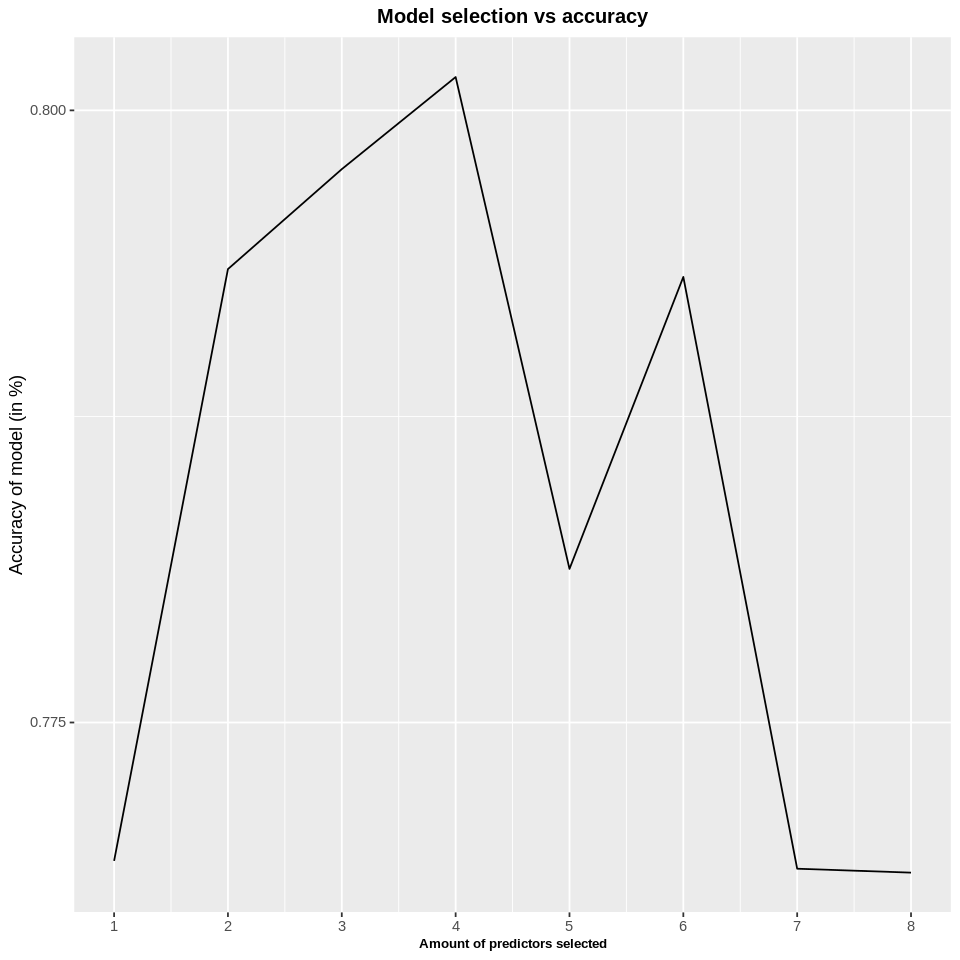

In [44]:
options(repr.plot.width = 8, repr.plot.height = 8)
model_selection_plot <- accuracies|>
  ggplot(aes(x=size,y=accuracy))+
  geom_line()+
  scale_x_continuous(breaks=c(1,2,3,4,5,6,7,8,9,10,11,12,13,14))+
  scale_y_continuous(breaks=c(0.75,0.775,0.8,0.825,0.85,0.875))+
  labs(x="Amount of predictors selected",y="Accuracy of model (in %)",
       title="Model selection vs accuracy")+
  theme(plot.title=element_text(size=12,face="bold",hjust=0.5))+
  theme(axis.title.x=element_text(size=8,face="bold",hjust=0.5))

model_selection_plot

From the graph above, we can see that ...

#### Initial Visualization
To add onto our summary statistics, we created box plots to visualize the relationship between our chosen predictor variables and the outcome for a patient's diagnosis (Figure 1). This will allow us to analyze the relationship between our predictor variables and the final patient outcome.

[1] "Figure 2"


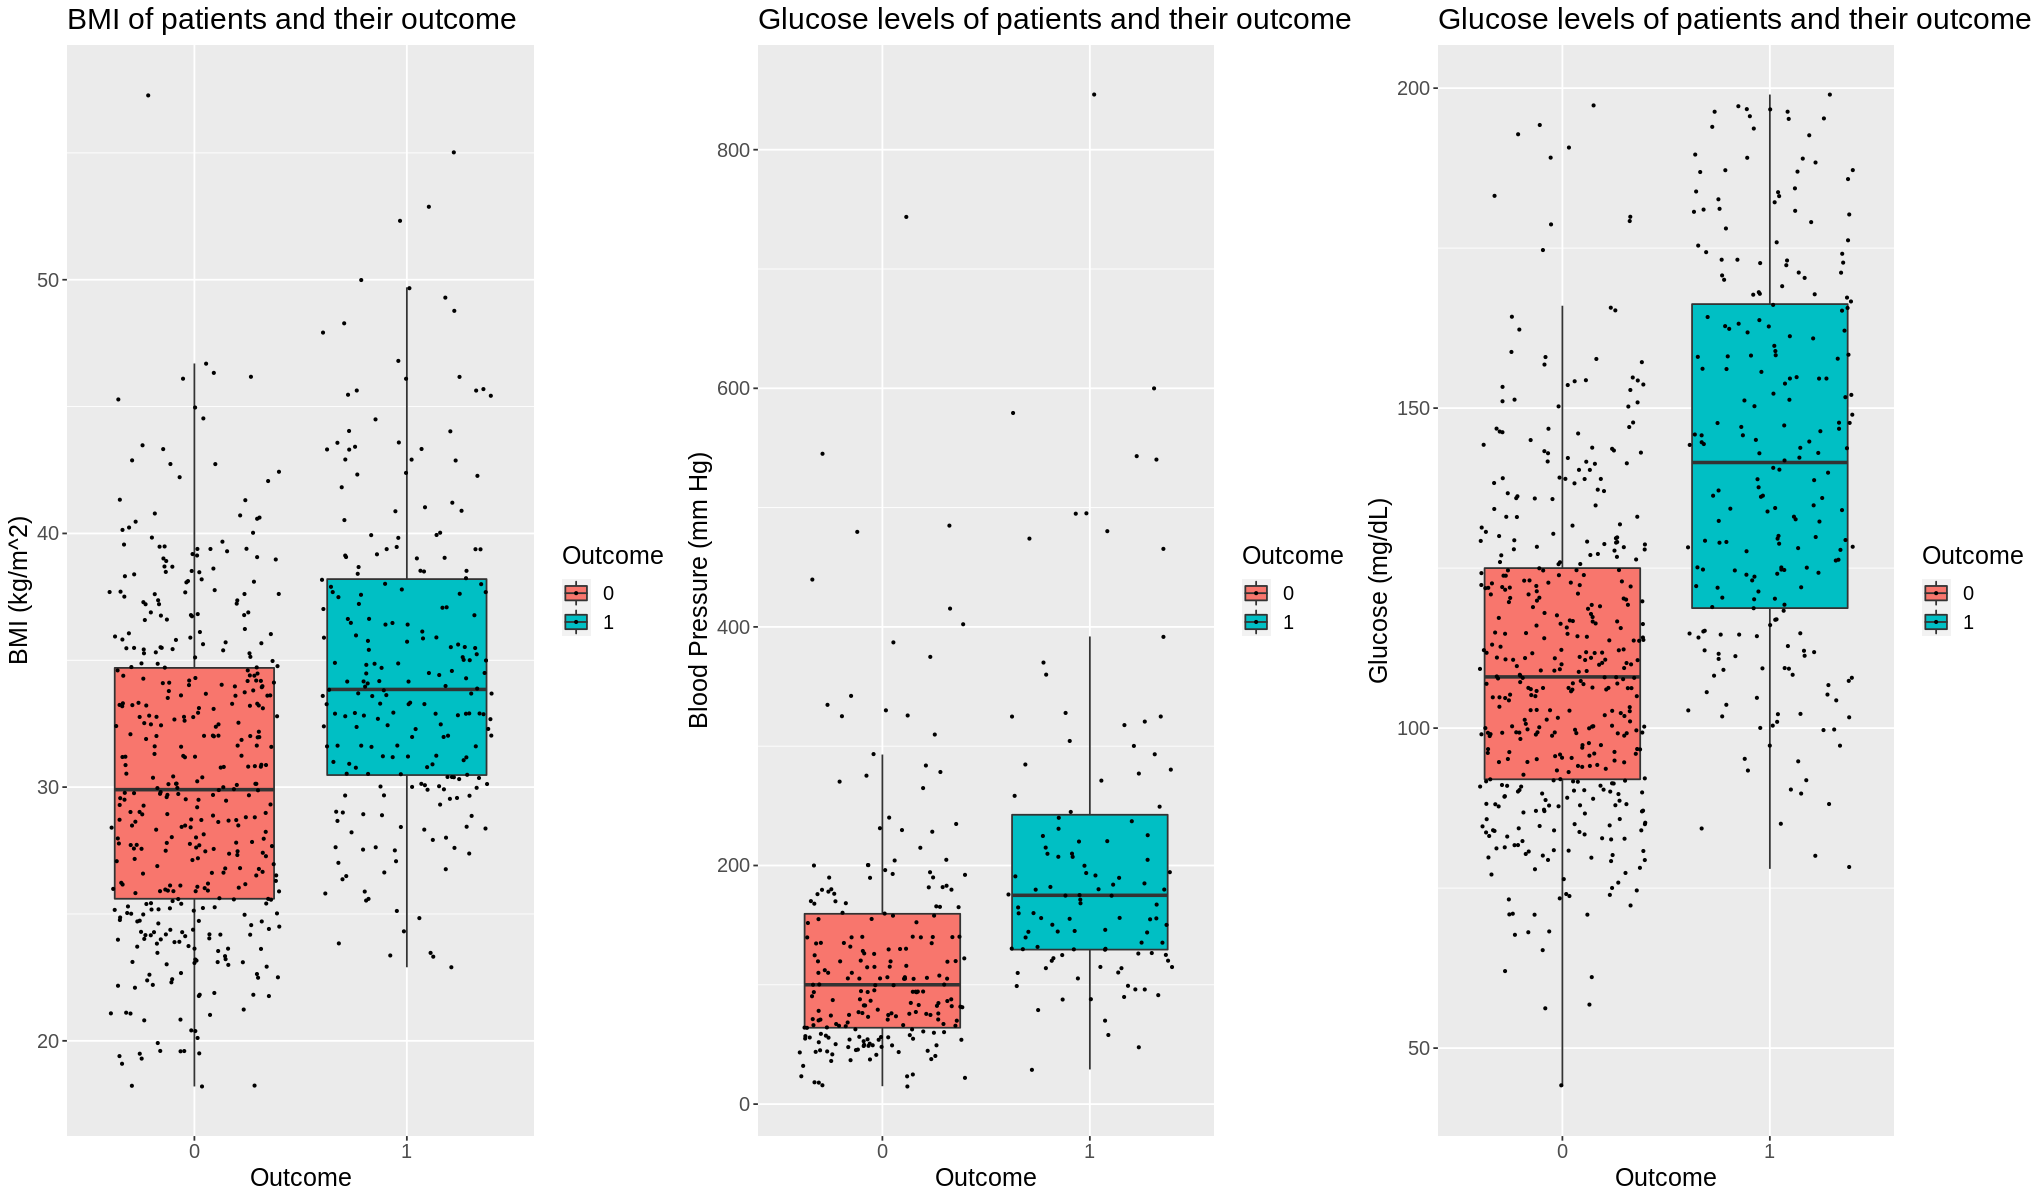

In [19]:
options(repr.plot.width = 17, repr.plot.height = 10)

BMI_plot <- diabetes_data_processed |>
    ggplot(aes(x = Outcome, y = BMI, fill = Outcome)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("BMI of patients and their outcome") +
        labs(x = "Outcome", y = "BMI (kg/m^2)") +
        theme(text = element_text(size = 15))

glucose_plot <- diabetes_data_processed |>
    ggplot(aes(x = Outcome, y = Glucose, fill = Outcome)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Glucose levels of patients and their outcome") +
        labs(x = "Outcome", y = "Glucose (mg/dL)") +
        theme(text = element_text(size = 15))

bloodpressure_plot <- diabetes_data_processed |>
    ggplot(aes(x = Outcome, y = Insulin, fill = Outcome)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Glucose levels of patients and their outcome") +
        labs(x = "Outcome", y = "Blood Pressure (mm Hg)") +
        theme(text = element_text(size = 15))

print("Figure 2")
grid.arrange(BMI_plot, bloodpressure_plot, glucose_plot,
             layout_matrix = rbind(c(1, 2, 3),
                                   c(1, 2, 3)))

Based on these preliminary box plots, we observe that our chosen predictor variables: BMI, blood pressure, and glucose, are all good indicators for predicting diabetes with glucose being the most distinct predictor. From analyzing these visualization, we had a few notable findings:
- All the predictors have a positive relationship with "Outcome" as an increased value leads to a presence of diabetes while a decreased value leads to an absence of diabetes

### 2. Building the Classifier
#### Splitting the Data
To prepare our data for a classification analysis, we split the data set into our training and testing set. Our data has 657 rows of data so 76% of the dataset will give us approximately 500 observations which is suitable to train the model. We decided that having a larger training set would give a more accurate model as it gives a good balance between training an accurate model and obtaining an accurate evaluation of the model's performance, therefore the proportion of splitting the data will be 76%.

In [14]:
set.seed(1400)

diabetes_split <- initial_split(diabetes_data_processed, prop = 0.76, strata = Outcome)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

#### Finding Best K Value
In order to create the most accurate classification model, we need to find an optimal k value that will produce the maximum accuracy for our results. We start by setting up our model specification for a KNN classification and finding the optimal k value. The data is split into five equal chunks to perform a cross-validation and tune the model to obtain a higher accuracy. We tested k values between 1 and 50 as any value larger than 50 would slow down the notebook. The recipe, model specification, and tuning process are all combined in a workflow to colect important metrics and finally filter for the accuracy.

In [15]:
diabetes_recipe <- recipe(Outcome ~ BMI + Glucose, data = diabetes_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
diabetes_recipe

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1)) 

diabetes_vfold <- vfold_cv(data = diabetes_train, v = 3, strata = Outcome)

knn_results <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = diabetes_vfold, grid = k_vals) |>
    collect_metrics()

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

x Fold1: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 163 or 1, not 166.

x Fold2: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 162 or 1, not 166.

x Fold3: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 164 or 1, not 166.



ERROR: [1m[33mError[39m in [1m[1m`estimate_tune_results()`:[22m
[33m![39m All of the models failed. See the .notes column.


With the workflow complete, we visualize the accuracy versus k value using a line plot ("Figure 2") to determine which k value will yield the higest accuracy.

In [13]:
accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracies_vs_k_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Number of Neighbours", y="Accuracy Estimate") +
    ggtitle("Number of Neighbours vs. Accuracy Estimate") +
    theme(text = element_text(size = 15))
print("Figure 3")
accuracies_vs_k_plot

ERROR: Error in filter(knn_results, .metric == "accuracy"): object 'knn_results' not found


As seen from the plot, we should use a k value of 25 because it gives us the highest accuracy estimate. Changing the k value to another nearby number by plus or minus one does not change accuracy significantly which shows that the k value is reliable.

#### Evaluating Model Accuracy
Using the new k value, the model is retrained on the training data with the specified k value. We use the same recipe with the new model specification which is combined in workflow to form our final model. This model is evaluated by predicting the testing observations from the testing data. We gather summary statistics on the model to analyze the quality including the accuracy.

In [ ]:
diabetes_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
    set_engine("kknn") |>
    set_mode("classification")
diabetes_spec

diabetes_fit <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(diabetes_spec) |>
    fit(data = diabetes_train)
diabetes_fit

diabetes_test_predictions <- predict(diabetes_fit, diabetes_test) |>
    bind_cols(diabetes_test)
head(diabetes_test_predictions)

diabetes_test_predictions |>
    metrics(truth = Outcome, estimate = .pred_class) |>
    filter(.metric == "accuracy")

From this, it can be seen that the accuracy of our classification model on the testing dataset is 72.3%. This percentage will be further analyzed in the discussion section.

### 3. Final Visualization of Results
We can visualize the accuracy of our model by creating two graphs, one with the actual "Outcome" values and one with the predicted "Outcome" values. This will allow us to compare the distribution of the predictions in the form of a scatter plot between our model predictions and the actual values.

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 10)

actual_data <- diabetes_test_predictions |>
    select(-.pred_class)

predicted_data <- diabetes_test_predictions |>
    select(-Outcome)

actual_graph <- ggplot(actual_data, aes(x = BMI, y = Glucose, colour = Outcome)) +
    geom_point(alpha = 0.6) +
    labs(x = "BMI (kg/m^2)", 
       y = "Glucose Levels (mg/dL)",
       color = "Diagnosis") +
    ggtitle("BMI vs. Glucose plot for actual Outcome") +
    theme(text = element_text(size = 15))

predicted_graph <- ggplot(predicted_data, aes(x = BMI, y = Glucose, colour = .pred_class)) +
    geom_point(alpha = 0.6) +
    labs(x = "BMI (kg/m^2)", 
       y = "Glucose Levels (mg/dL)",
       color = "Diagnosis") +
    ggtitle("BMI vs. Glucose plot for predicted Outcome") +
    theme(text = element_text(size = 15))

print("Figure 4")
grid.arrange(actual_graph, predicted_graph,
             layout_matrix = rbind(c(1, 2),
                                   c(1, 2)))

As we can see from the graphs above, the classification model was able to accurately predict most of the data near the bottom and top of the graph as they are no diabetes ("0") or diabetes ("1"), but it is less accurate near the center of the graph. At the center of the graph where the data overlaps more, the model predicted almost all of the observations to have no diabetes while the actual values were a mixture of both. These graphs show that the model is most accurate for extreme values of glucose and BMI and become less accurate when the values are closer to the normal and overlap with each other.

## Discussion: ##

## References ##

Diabetes Facts & Figures. International Diabetes Federation. (2021, September 12). Retrieved March 10, 2023 from https://idf.org/aboutdiabetes/what-is-diabetes/facts-figures.html#:~:text=The%20IDF%20Diabetes%20Atlas%20Tenth,and%20783%20million%20by%202045. 

What is Diabetes? Centers for Disease Control and Prevention. (2022, July 7). Retrieved March 11, 2023, from https://www.cdc.gov/diabetes/basics/diabetes.html#:~:text=Diabetes%20is%20a%20chronic%20(long,your%20pancreas%20to%20release%20insulin 

What is Diabetes? National Institute of Diabetes and Digestive and Kidney Diseases. (2016, December). Retrieved March 11, 2023, from https://www.niddk.nih.gov/health-information/diabetes/overview/what-is-diabetes